In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from sklearn.metrics import f1_score
from tqdm import tqdm
from IPython.display import clear_output
from datetime import datetime

In [2]:
# загрузка данных о героях
with open('data/dota_hero_info.json', 'r') as f:
    names_by_id = json.load(f)


ids_by_name = {}
for idx, name in names_by_id.items():
    ids_by_name[name] = int(idx)

# получение строки текущего времени
def get_curent_time():
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    for key in "_/: ":
        dt_string = dt_string.replace(key,'_')
    return dt_string 

# перевод из id в имя для 1D списка
def get_ids_by_names(names:list ,ids_by_name:dict = ids_by_name): 
    ids = []
    for name in names:
        if type(name)==str:
            name = ids_by_name[name]        
        ids.append(name)
    return ids

# one hot encoding фичей для входа NN 
def transformer(feature,n_dota_heroes=150):
    radiant = torch.sum(F.one_hot(feature[:5],num_classes=n_dota_heroes),0)
    dire = torch.sum(F.one_hot(feature[5:],num_classes=n_dota_heroes),0)     
    match_feature = torch.cat((torch.LongTensor(radiant).to(torch.float32),
                              torch.LongTensor(dire).to(torch.float32)),
                              dim=-1
                             )
    return match_feature 


class SparceDaraset(TensorDataset):
    def __init__(self,features, result, transformer, n_dota_heroes=150):
        self.n_dota_heroes = n_dota_heroes  
        self.transformer = transformer
        self.result = result         
        self.features = features     
        
        
    def __len__(self,):
        return len(self.result)
    
    def __getitem__(self,idx):
        feature = self.features[idx,:]
        feature = self.transformer(feature)
        
        return feature,self.result[idx,:]

    
# структура NN    
class NN_dota2(nn.Module):
    def __init__(self, out_features=2,n_dota_heroes=150, hidden_layer=512):
        super().__init__()
        self.lin_linear_1 = nn.Linear(n_dota_heroes*2,hidden_layer)
        self.lin_linear_2 = nn.Linear(hidden_layer,hidden_layer)
        self.lin_linear_3 = nn.Linear(hidden_layer, out_features)
        self.relu = nn.ReLU()        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):        
        x = self.lin_linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin_linear_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin_linear_3(x)
        return x     

# разбиение данных на feature, target
def feature_target_preprocessing(data,
                         feature_columns= ['radiant_hero_1', 'radiant_hero_2','radiant_hero_3', 'radiant_hero_4', 'radiant_hero_5',
                                           'dire_hero_1','dire_hero_2', 'dire_hero_3', 'dire_hero_4', 'dire_hero_5',],
                         target_columns = ['radiant_win']
                        ):
    """
    
    """
    feature = data[feature_columns]
    target = pd.get_dummies(data[target_columns].iloc[:,0])
    
    feature = torch.from_numpy(feature.to_numpy()).to(torch.int64)
    target = torch.from_numpy(target.to_numpy()).to(torch.int64)
    return feature, target
    

# обучение модели
def train_model(model,train_loader,val_loader,optimizer,n_epoch: int,name='model_27',draw=False):
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_acc2 = []
    last_accuracy = 0
    curent_time = get_curent_time()
    for epoch in tqdm(range(n_epoch)):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        
        model.train(True)
        for X_batch, y_batch in train_loader:            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)            
            
            prediction = model(X_batch)
            loss = loss_function(prediction, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            ep_train_loss.append(loss.item())
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                prediction = model(X_batch)
                loss = loss_function(prediction, y_batch.float())
                ep_val_loss.append(loss.item())                
                y_pred = sigmoid(prediction)
                
                # для валидации средяя величина ошибки исхода матча
                ep_val_accuracy.append(np.mean(torch.abs((y_batch[:,1]-sigmoid(y_pred[:,1]))).cpu().detach().numpy())) ## accuracy method
                                       
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy)) 
        
        # сохранение состояния модели 
        if (epoch ==0) or (abs(val_accuracy[-1])<abs(last_accuracy)):
            last_accuracy = val_accuracy[-1]
            model_name = f'model_state_dict/{curent_time}_{name}_epoch{epoch}.pth'
            torch.save(model.state_dict(), model_name)
        
        # отображение обучения модели
        if draw:
            if epoch==0:
                fig,ax = plt.subplots()     
            clear_output(True)
            fig, ax = plt.subplots(1,2)
            ax[0].plot(train_loss,label='train')
            ax[0].plot(val_loss,label='val')
            ax[1].plot(val_accuracy)
            ax[0].legend()
            plt.show() 

    return train_loss,val_loss,val_accuracy

def names_lists_to_id(names:list):
    hero_list = []
    ids = []
    for row in names:        
        
        ids.append(get_ids_by_names(row))
        
    feature_tensor = torch.from_numpy(np.array(ids)).to(torch.int64)
    return feature_tensor

def get_matches_preds(matches,model,):
    matches_names_id = names_lists_to_id(matches)
    preds = []
    for match in matches_names_id:    
        logits = model(transformer(match).to(device))
        prediction = sigmoid(logits)
        preds.append(prediction)
    
    return preds



In [3]:
softmax = nn.Softmax(dim=1)
sigmoid = nn.Sigmoid()

model = NN_dota2(hidden_layer=512)
summary(model,(1, 300),device='cpu')     
device = 'cuda' if torch.cuda.is_available else 'cpu'
model.to(device)  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         154,112
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 512]         262,656
              ReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7                 [-1, 1, 2]           1,026
Total params: 417,794
Trainable params: 417,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.59
Estimated Total Size (MB): 1.62
----------------------------------------------------------------


NN_dota2(
  (lin_linear_1): Linear(in_features=300, out_features=512, bias=True)
  (lin_linear_2): Linear(in_features=512, out_features=512, bias=True)
  (lin_linear_3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# обучение модели 

train_data = pd.read_csv('data/train_data.csv')
X_train,y_train = feature_target_preprocessing(train_data)
val_data = pd.read_csv('data/val_data.csv')
X_val,y_val = feature_target_preprocessing(val_data)

BATCH = 64

train_dataset = SparceDaraset(X_train,y_train,transformer)
train_loader = DataLoader(train_dataset, batch_size=BATCH)

val_dataset = SparceDaraset(X_val,y_val,transformer)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

loss_function = nn.BCEWithLogitsLoss()
optimizer =torch.optim.Adam(model.parameters(),)

n_epoch = 200
train_loss,val_loss,val_accuracy=train_model(model,train_loader,val_loader,optimizer,n_epoch,draw=True)

In [4]:
# загрузка весов модели
PATH = 'model/model_SD_40loss.pth'
model.load_state_dict(torch.load(PATH,map_location=device))

model.to(device)
model.eval()

NN_dota2(
  (lin_linear_1): Linear(in_features=300, out_features=512, bias=True)
  (lin_linear_2): Linear(in_features=512, out_features=512, bias=True)
  (lin_linear_3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
# проверка модели на тестовых данных
test_data = pd.read_csv('data/test_data.csv')
X_test, y_test = feature_target_preprocessing(test_data)

test_dataset = SparceDaraset(X_test,y_test,transformer)
test_loader = DataLoader(test_dataset, batch_size=len(test_data))

test_data = next(iter(test_loader))
logits = model(test_data[0].to(device))
predictions = sigmoid(logits)
error_array = np.sort(np.abs((predictions[:,1].cpu() - y_test[:,1]).detach().numpy()))

В качестве метрики для каждого матча была посчитана величина ошибки, для понимания доли 
правильно предсказанных матчей при заданой величине уверенности в прогнозе

при уверенности модели равной (0.1) доля правильно предсказанных матчей равна 0.799


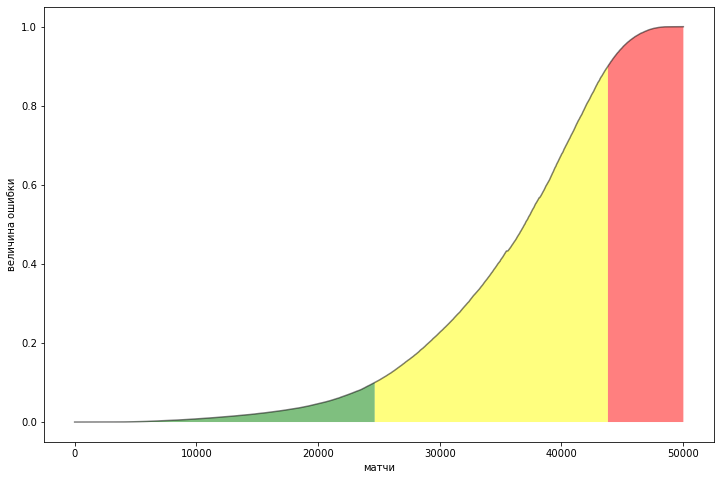

In [6]:

error_value = 0.1
left_index = sum(error_array<error_value)-1
right_index = sum(error_array<(1-error_value))-1
fig,ax = plt.subplots(figsize=(12,8))

green_length = left_index
yellow_length = right_index-left_index
red_length = len(error_array)-right_index
alpha=0.5

ax.plot(error_array,alpha=alpha,color='black')
ax.fill_between(np.arange(green_length),
                np.zeros(green_length),
                error_array[:left_index],
                where=error_array[left_index]>np.zeros(left_index),
                alpha=alpha,
                facecolor ='green') # 
ax.fill_between(np.arange(yellow_length)+left_index,
                np.zeros(yellow_length),
                error_array[left_index:right_index],
                where=error_array[left_index:right_index]>np.zeros(yellow_length),
                alpha=alpha,
                facecolor ='yellow') # 
ax.fill_between(np.arange(red_length)+right_index,
                np.zeros(red_length),
                error_array[right_index:],
                where=error_array[right_index]>np.zeros(len(error_array)-right_index),
                alpha=alpha,
                facecolor ='red') # 

ax.set_ylabel('величина ошибки')
ax.set_xlabel('матчи')
print(F'при уверенности модели равной ({error_value}) доля правильно предсказанных матчей равна \
{green_length/(green_length+red_length):.3f}')

In [7]:
# использование модели (первая половина списка - radiant, вторая - dire)
matches = [['Tinker','Undying','Bristleback','Gyrocopter','Winter Wyvern',
        'Clinkz','Marci','Phantom Assassin','Outworld Destroyer','Dazzle',
           ],
         ['Dark Seer','Timbersaw','Disruptor','Terrorblade','Techies',
        'Lich','Broodmother','Ember Spirit','Batrider','Juggernaut',             
         ],
         ['Templar Assassin','Viper','Faceless Void','Anti-Mage','Bristleback',
        'Clinkz','Ursa','Void Spirit','Enigma','Monkey King',             
         ],
          ['Lich','Phantom Lancer','Spirit Breaker','Kunkka','Templar Assassin',
        'Tusk','Wraith King','Grimstroke','Oracle','Queen of Pain',             
         ] 
          ]
preds = get_matches_preds(matches,model,)
print('уверенность модели в победе dire/radiant')
preds

уверенность модели в победе dire/radiant


[tensor([0.0169, 0.9831], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([0.0433, 0.9567], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([1.0338e-05, 9.9999e-01], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([0.0122, 0.9878], device='cuda:0', grad_fn=<SigmoidBackward0>)]

In [8]:
names_by_id

{'1': 'Anti-Mage',
 '2': 'Axe',
 '3': 'Bane',
 '4': 'Bloodseeker',
 '5': 'Crystal Maiden',
 '6': 'Drow Ranger',
 '7': 'Earthshaker',
 '8': 'Juggernaut',
 '9': 'Mirana',
 '10': 'Morphling',
 '11': 'Shadow Fiend',
 '12': 'Phantom Lancer',
 '13': 'Puck',
 '14': 'Pudge',
 '15': 'Razor',
 '16': 'Sand King',
 '17': 'Storm Spirit',
 '18': 'Sven',
 '19': 'Tiny',
 '20': 'Vengeful Spirit',
 '21': 'Windranger',
 '22': 'Zeus',
 '23': 'Kunkka',
 '25': 'Lina',
 '26': 'Lion',
 '27': 'Shadow Shaman',
 '28': 'Slardar',
 '29': 'Tidehunter',
 '30': 'Witch Doctor',
 '31': 'Lich',
 '32': 'Riki',
 '33': 'Enigma',
 '34': 'Tinker',
 '35': 'Sniper',
 '36': 'Necrophos',
 '37': 'Warlock',
 '38': 'Beastmaster',
 '39': 'Queen of Pain',
 '40': 'Venomancer',
 '41': 'Faceless Void',
 '42': 'Wraith King',
 '43': 'Death Prophet',
 '44': 'Phantom Assassin',
 '45': 'Pugna',
 '46': 'Templar Assassin',
 '47': 'Viper',
 '48': 'Luna',
 '49': 'Dragon Knight',
 '50': 'Dazzle',
 '51': 'Clockwerk',
 '52': 'Leshrac',
 '53': "Natu